In [1]:
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType

# from sentinelhub import BBox, CRS
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

from eolearn.core import SaveToDisk, LoadFromDisk, EOTask
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput, ExportToTiff

In [2]:
# # reference time

# date_first_start = '2019-04-18'
# date_first_end = '2019-04-20'

# date_last_start = '2019-08-21'
# date_last_end = '2019-08-22'

In [3]:
class NormalBurningRatio(EOTask):
    """
    NBR = (9 - 12)/(9 + 12)
    DNBR = NBR_2 - NBR_1
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        nbr = (band_a - band_b)/(band_a + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, nbr[..., np.newaxis])

        return eopatch    

In [4]:
roi_bbox = BBox(bbox=[27.48, 51.75, 27.57, 51.64], crs=CRS.WGS84)

In [5]:
layer = 'BANDS-S2-L1C'

custom_script = 'return [B04, B08, B08A, B09, B11, B12];'
input_task = S2L1CWCSInput(
    layer=layer,
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='20m', # resolution x
    resy='20m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

add_ndvi = S2L1CWCSInput(layer='NDVI')

add_nbr = NormalBurningRatio('NBR', 'BANDS/3','BANDS/5')

tiff_location = './predicted_tiff_D'

add_dem = DEMWCSInput(layer='DEM')

#add_l2a = S2L2AWCSInput(layer='BANDS-S2-L2A')

add_sen2cor = AddSen2CorClassificationFeature('SCL', layer='BANDS-S2-L2A')

save = SaveToDisk('io_example', overwrite_permission=2, compress_level=1)

In [6]:
%%time

time_interval = ('2019-04-10', '2019-04-21')
workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 37.8 s


In [7]:
eopatch = result[save]
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(4, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(4, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(4, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-10', '2019-04-21')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 11, 9, 17, 27), ..., datetime.datetime(2019, 4, 21, 9, 31, 57)], length=4
)

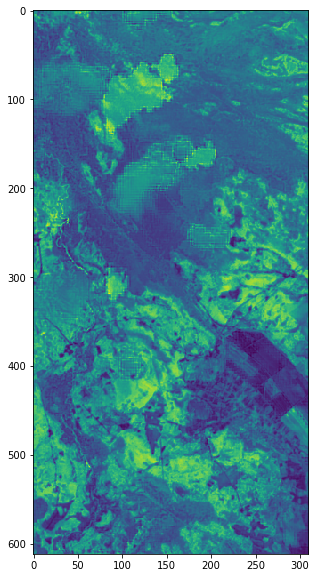

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['NBR'][3].squeeze());

In [60]:
%%time

time_interval = ('2019-05-21', '2019-06-10')
workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result_new = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

c:\users\frolui\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Wall time: 1min 26s


In [51]:
eopatch_new = result_new[save]
eopatch_new

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(4, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(4, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(4, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-05-21', '2019-05-30')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 5, 24, 9, 26, 6), ..., datetime.datetime(2019, 5, 29, 9, 26, 5)], length=4
)

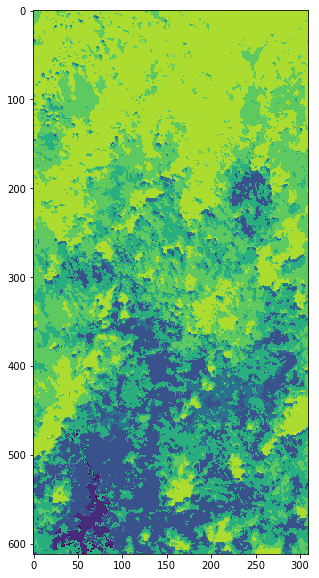

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch_new.mask['SCL'][3].squeeze());

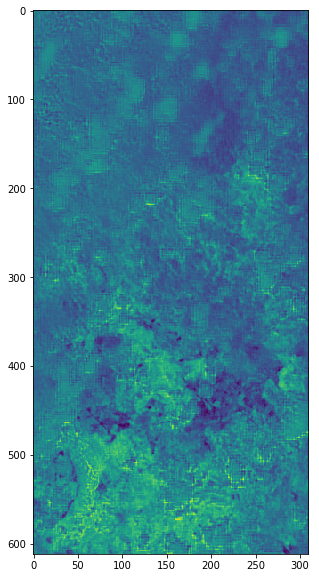

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch_new.data['NBR'][3].squeeze());

In [53]:
delta_nbr = eopatch.data['NBR'] - eopatch_new.data['NBR']
delta_nbr_1 = eopatch_new.data['NBR'] - eopatch.data['NBR']

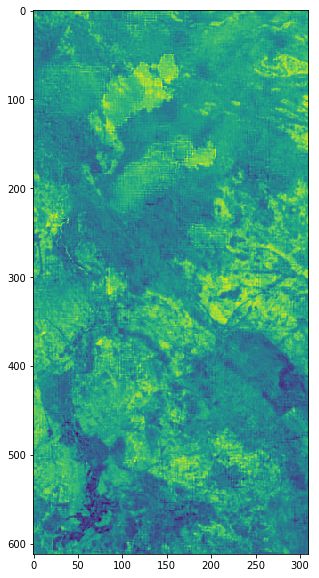

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr[3].squeeze());

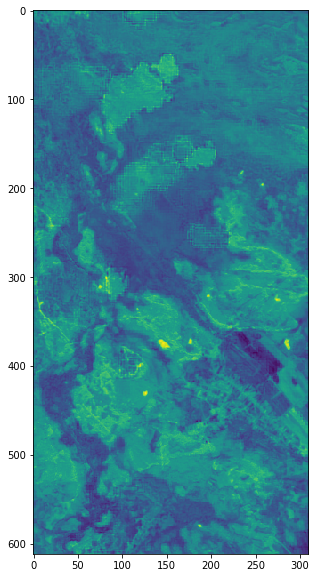

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr[3].squeeze());